helper function for viewing a densely arranged grid of spectrograms without axes

this implementation accepts a list of audio clips, but can be easily adapted to accept lists of Spectrograms or Tensors

In [ ]:
import torch
import torchvision.utils as vutils
from opensoundscape import Audio, Spectrogram, CNN, BoxedAnnotations
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


def review_audio_grid(
    audio_list=None,
    spec_list=None,
    tensor_list=None,
    columns=3,
    white_borders=False,
    spec_params=None,
    range=[-100, -20],
    bandpass_freqs=None,
):
    """plot grid of audio spectrograms

    pass in a list of audio files, spectrograms, or torch tensors
    - only provide one of the three arguments: audio_list, spec_list, or tensor_list


    Args:
        audio_list (list): list of audio files
        spec_list (list): list of spectrograms
        tensor_list (list): list of torch tensors
        columns (int): number of columns in grid of displayed specs
        white_borders (bool): if True, uses white instead of black pixels for padding
        spec_params (dict): dictionary of kwargs for Spectrogram.from_audio
        range (list): limits of spectrogram values to map to black/white pixels, default [-100, -20] dB
        bandpass_freqs (list): crop specs to this frequency range
            - not used if tensor_list is provided instead of audio or spectrograms
    """
    spec_params = spec_params or {}

    if audio_list is not None:
        assert (
            spec_list is None and tensor_list is None
        ), "only provide one of the three arguments: audio_list, spec_list, or tensor_list"
        spec_list = [Spectrogram.from_audio(a, **spec_params) for a in audio_list]
    elif spec_list is not None:
        assert (
            audio_list is None and tensor_list is None
        ), "only provide one of the three arguments: audio_list, spec_list, or tensor_list"

    if tensor_list is None:
        # bandpass
        if bandpass_freqs is not None:
            spec_list = [s.bandpass(*bandpass_freqs) for s in spec_list]
        # Create a list of 2D tensors
        tensor_list = [
            torch.tensor(s.to_image(return_type="torch", invert=True, range=range))
            for s in spec_list
        ]

    # Make a grid
    grid = vutils.make_grid(tensor_list, nrow=columns, pad_value=int(white_borders))

    # Display the grid
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

In [ ]:
# example usage with audio_list
a = Audio.from_url("https://www.xeno-canto.org/631853/download")
clips, clip_df = a.split(2)
review_audio_grid(
    audio_list=clips, spec_params=dict(window_samples=512), bandpass_freqs=[2000, 7000]
)

In [ ]:
# example with spectrogram_list
specs = [Spectrogram.from_audio(a) for a in clips]
review_audio_grid(spec_list=specs)

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_12329/4150171045.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = [torch.tensor(s.to_image(return_type="torch", invert=True)) for s in specs]


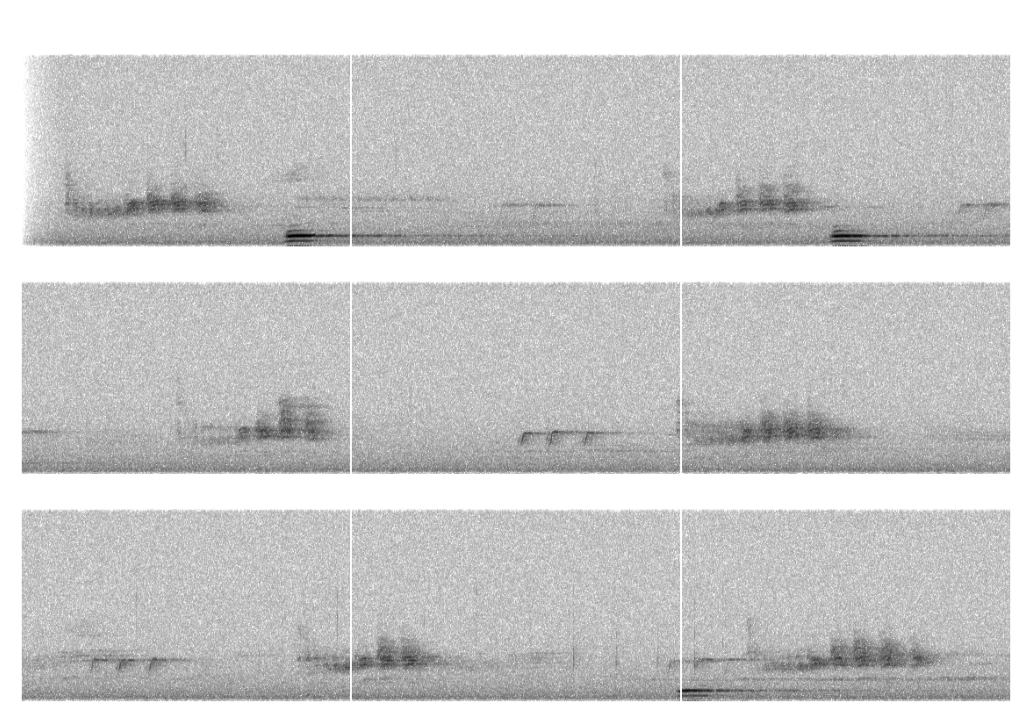

In [ ]:
# example with tensors
tensors = [torch.tensor(s.to_image(return_type="torch", invert=True)) for s in specs]
review_audio_grid(tensor_list=tensors, white_borders=True)